<a href="https://colab.research.google.com/github/Favourj-bit/DSN_AIB_2023_submission/blob/main/Favour_James_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install lightgbm catboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
train = pd.read_csv("Housing_dataset_train.csv")
test = pd.read_csv("Housing_dataset_test.csv")
sub = pd.read_csv("Sample_submission.csv")

In [4]:
train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.00,2.00,1.00,1149999.56
1,2748,Ondo,Apartment,NaN,2.00,4.00,1672416.69
2,9261,Ekiti,NaN,7.00,5.00,NaN,3364799.81
3,2224,Anambra,Detached duplex,5.00,2.00,4.00,2410306.76
4,10300,Kogi,Terrace duplex,NaN,5.00,6.00,2600700.90


In [5]:
train[train['price'] > 0].reset_index(drop = True)

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.00,2.00,1.00,1149999.56
1,2748,Ondo,Apartment,NaN,2.00,4.00,1672416.69
2,9261,Ekiti,NaN,7.00,5.00,NaN,3364799.81
3,2224,Anambra,Detached duplex,5.00,2.00,4.00,2410306.76
4,10300,Kogi,Terrace duplex,NaN,5.00,6.00,2600700.90
...,...,...,...,...,...,...,...
13995,6175,Edo,Bungalow,NaN,7.00,NaN,2367927.86
13996,9704,Kaduna,Apartment,NaN,7.00,5.00,2228516.47
13997,11190,Plateau,Bungalow,8.00,6.00,5.00,2406812.69
13998,9256,Delta,Flat,NaN,6.00,1.00,3348918.72


# EDA

In [6]:
train.describe()

,ID,bedroom,bathroom,parking_space,price
count,14000.00,12201.00,12195.00,12189.00,14000.00
mean,4862.70,4.31,3.13,3.17,2138081.75
std,3818.35,2.44,2.04,1.60,1083056.66
min,0.00,1.00,1.00,1.00,431967.29
25%,1672.75,2.00,1.00,2.00,1393989.52
50%,3527.00,4.00,2.00,3.00,1895223.07
75%,8011.25,6.00,5.00,4.00,2586699.49
max,12999.00,9.00,7.00,6.00,16568486.16


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


In [8]:
test.head()

,ID,loc,title,bedroom,bathroom,parking_space
0,845,Kano,Penthouse,4,1,2
1,1924,Adamawa,Apartment,2,2,4
2,10718,Adamawa,Bungalow,2,7,2
3,12076,Lagos,Mansion,9,5,2
4,12254,Gombe,Semi-detached duplex,5,6,1


In [9]:
train.title.unique() #checking unique house titles in the dataset

array(['Semi-detached duplex', 'Apartment', nan, 'Detached duplex',
       'Terrace duplex', 'Mansion', 'Bungalow', 'Penthouse', 'Townhouse',
       'Flat', 'Cottage'], dtype=object)

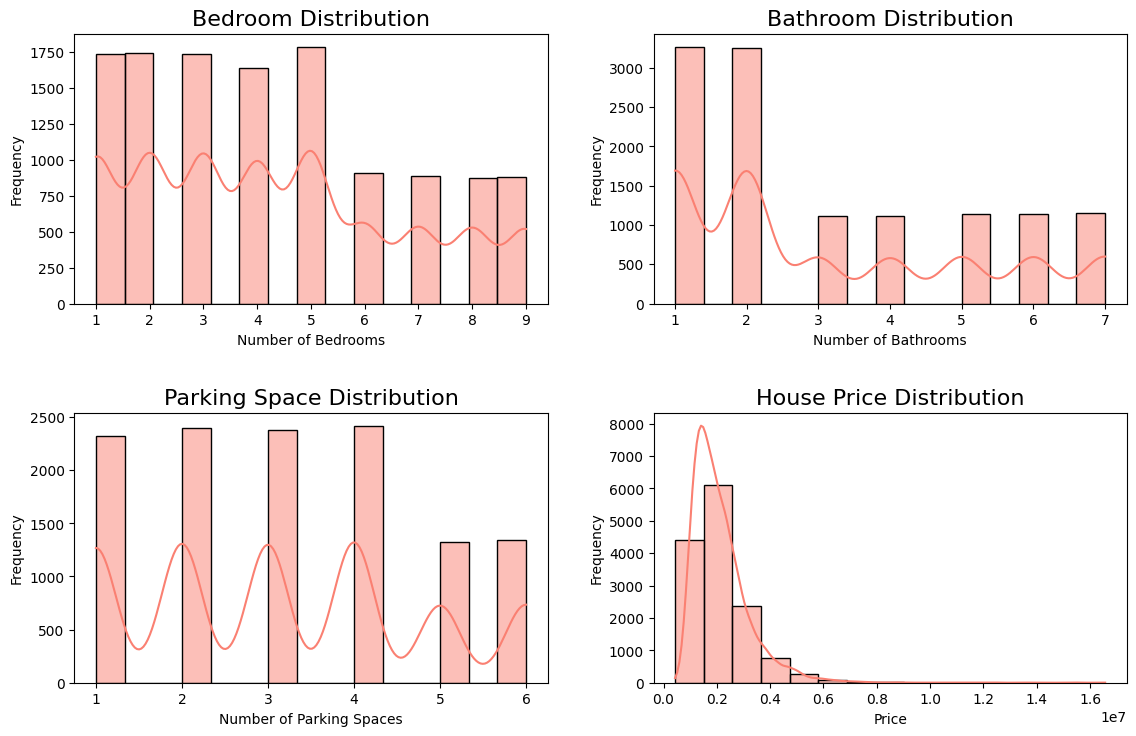

In [10]:
# Distribution plots for numeric features

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(train['bedroom'], kde=True, bins=15, color='salmon', edgecolor='black')
plt.title('Bedroom Distribution', fontsize=16)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(train['bathroom'], kde=True, bins=15, color='salmon', edgecolor='black')
plt.title('Bathroom Distribution', fontsize=16)
plt.xlabel('Number of Bathrooms')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(train['parking_space'], kde=True, bins=15, color='salmon', edgecolor='black')
plt.title('Parking Space Distribution', fontsize=16)
plt.xlabel('Number of Parking Spaces')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(train['price'], kde=True, bins=15, color='salmon', edgecolor='black')
plt.title('House Price Distribution', fontsize=16)
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.tight_layout(pad=3.0)
plt.show()

### Univariate Analysis.

Univariate analysis in data visualization refers to the examination and representation of a single variable at a time. It is the simplest form of data analysis and is used to understand the distribution, central tendency, and dispersion of individual variables in a dataset.

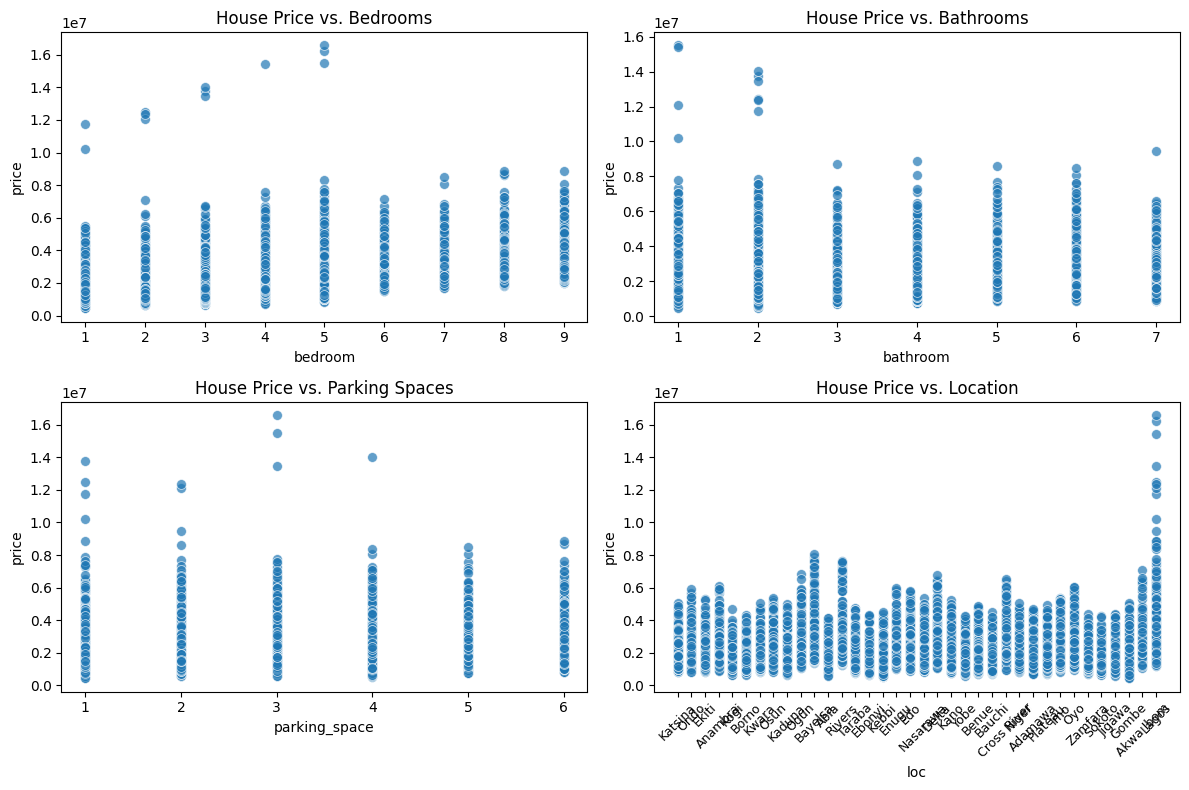

In [11]:

plt.figure(figsize=(12, 8))


plt.subplot(2, 2, 1)
sns.scatterplot(data=train, x='bedroom', y='price', alpha=0.7, s=50)
plt.title('House Price vs. Bedrooms')

plt.subplot(2, 2, 2)
sns.scatterplot(data=train, x='bathroom', y='price', alpha=0.7, s=50)
plt.title('House Price vs. Bathrooms')

plt.subplot(2, 2, 3)
sns.scatterplot(data=train, x='parking_space', y='price', alpha=0.7, s=50)
plt.title('House Price vs. Parking Spaces')

plt.subplot(2, 2, 4)
sns.scatterplot(data=train, x='loc', y='price', alpha=0.7, s=50)
plt.title('House Price vs. Location')
plt.xticks(rotation=45, fontsize=9)

plt.tight_layout()
plt.show()

Visualisation to show houses based on price

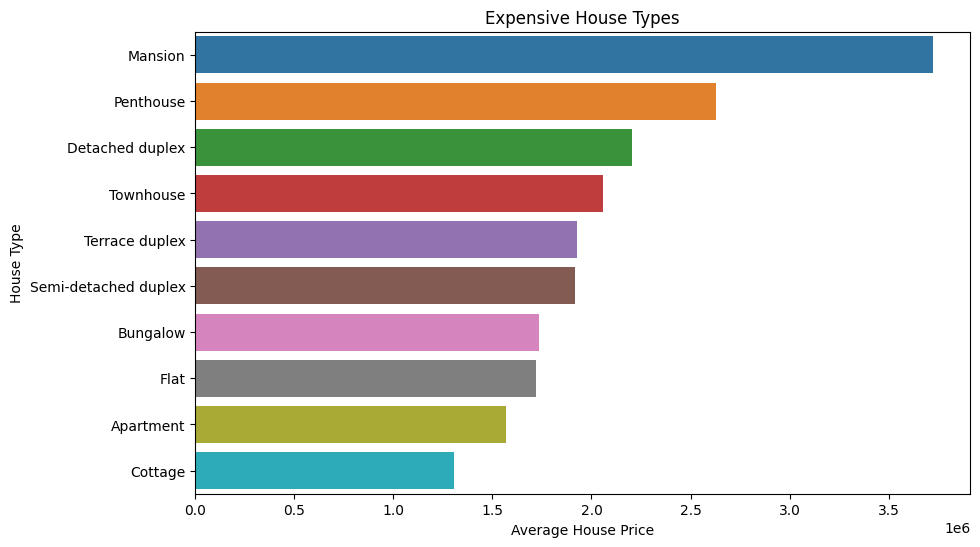

In [12]:
# Calculate the average house price for each house type
housetype_average_prices = train.groupby('title')['price'].mean().reset_index()

# Sort the house types based on the average house price in descending order
top_expensive = housetype_average_prices.sort_values(by='price', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_expensive, x='price', y='title')
plt.xlabel('Average House Price')
plt.ylabel('House Type')
plt.title('Expensive House Types')
plt.show()

Visualisation of average house prices

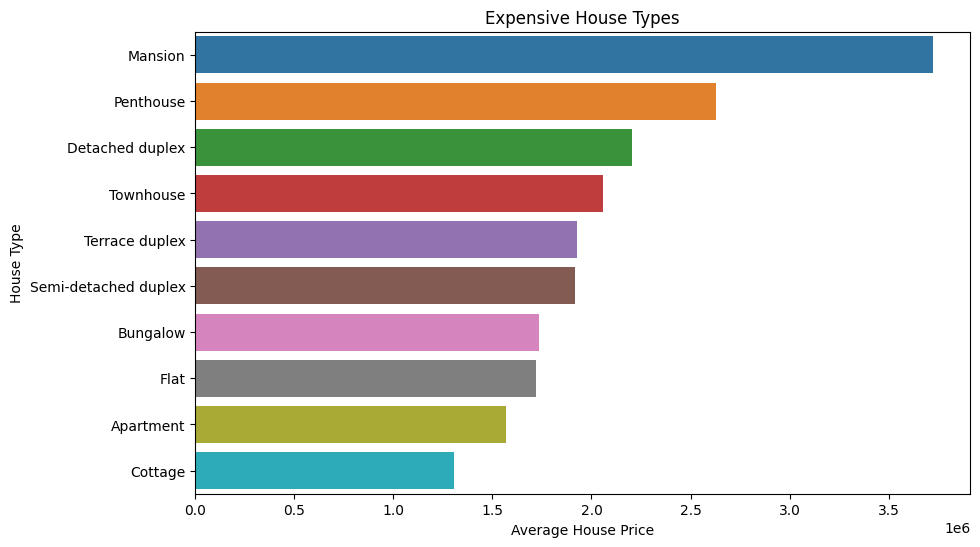

In [13]:
# Calculate the average house price for each house type
housetype_average_prices = train.groupby('title')['price'].mean().reset_index()

# Sort the house types based on the average house price in descending order
top_expensive = housetype_average_prices.sort_values(by='price', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_expensive, x='price', y='title')
plt.xlabel('Average House Price')
plt.ylabel('House Type')
plt.title('Expensive House Types')
plt.show()

## Data Cleaning and Feature Engieering

In [14]:
#merge the data to perform analysis on both train and test

data = pd.concat([train, test], ignore_index=True)

In [15]:
# Define the ranking based on size (arranged from smallest to biggest)
house_type_ranks = {
    'Cottage': 1,
    'Bungalow': 2,
    'Townhouse': 3,
    'Terrace duplex': 4,
    'Detached duplex': 5,
    'Semi-detached duplex': 6,
    'Flat': 7,
    'Penthouse': 8,
    'Apartment': 9,
    'Mansion': 10
}

# Map the house types to numerical values based on size ranking
data['title'] = data['title'].map(house_type_ranks)

# Print the updated dataframe
data.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,6.00,2.00,2.00,1.00,1149999.56
1,2748,Ondo,9.00,NaN,2.00,4.00,1672416.69
2,9261,Ekiti,NaN,7.00,5.00,NaN,3364799.81
3,2224,Anambra,5.00,5.00,2.00,4.00,2410306.76
4,10300,Kogi,4.00,NaN,5.00,6.00,2600700.90


In [16]:
#frequency encoding
data['loc_freq'] = data['loc'].dropna().map(data['loc'].value_counts())

In [17]:
# label encoding
unique_loc = data['loc'].dropna().unique()
loc_dict = {category: idx + 1 for idx, category in enumerate(unique_loc)}

data['loc'] = data['loc'].map(loc_dict)
unique_title = data['title'].dropna().unique()
title_dict = {category: idx + 1 for idx, category in enumerate(unique_title)}

data['title'] = data['title'].map(title_dict)

In [18]:
df_train = data.iloc[:len(train)]
df_test = data.iloc[len(train):]

In [19]:
features = df_train.drop(columns=["price"]).columns.to_list()
target = "price"

# Modelling

In [19]:
X, y = df_train[features], df_train[target]

In [20]:
X.shape, y.shape

((14000, 7), (14000,))

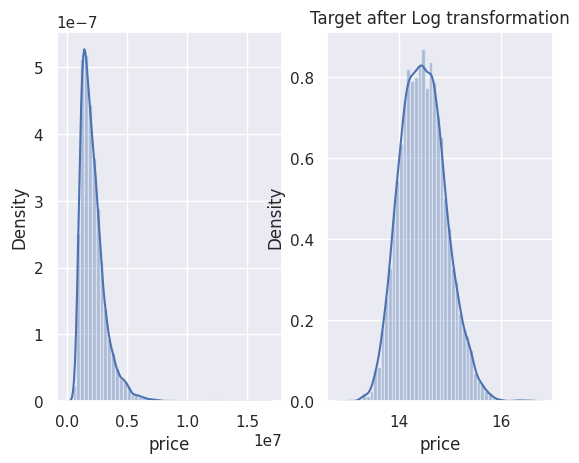

In [33]:
sns.set()
y_transformed = pd.Series(np.log1p(y))

fig, ax = plt.subplots(1, 2)
sns.distplot(y, ax=ax[0])
plt.title("Target after Log transformation")
# ax[0].axvline(y_transformed)
sns.distplot(y_transformed, ax=ax[1])
plt.show()

Modelling with transformed target column

In [35]:
fold_pred=[]
oof_pred = []


params = {'n_estimators': 1650,
 'learning_rate': 0.01818940960110315,
 'subsample': 0.5341522889468363,
 'colsample_bytree': 0.44186887868831437,
 'max_depth': 5}



fold = KFold(n_splits=7, shuffle=True)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.log1p(y.iloc[train_index]), y.iloc[test_index]

    model = LGBMRegressor(**params, objective = "rmse")
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100, verbose = False)#erly100

    preds= model.predict(X_test)
    print("err: ",(mean_squared_error(y_test,np.expm1(preds), squared=False)))  #Reverse transformation
    oof_pred.append(mean_squared_error(y_test,np.expm1(preds),squared=False))
    p2 = model.predict(df_test[X.columns])
    fold_pred.append(np.expm1(p2))


print(np.mean(oof_pred))

err:  501132.70088116993
err:  502367.6414803696
err:  534541.1721376815
err:  529049.2012994407
err:  497503.6615892198
err:  502682.9791816254
err:  626659.5532773237
527705.2728352614


Modelling without transformation

In [28]:
fold_pred=[]
oof_pred = []


params = {'n_estimators': 1650,
 'learning_rate': 0.01818940960110315,
 'subsample': 0.5341522889468363,
 'colsample_bytree': 0.44186887868831437,
 'max_depth': 5}


fold = KFold(n_splits=5, shuffle=True, random_state=42)
# fold = KFold(n_splits=5, shuffle=False)
for train_index, test_index in fold.split(X,y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LGBMRegressor(**params, objective = "rmse")
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=150, verbose = False)

    preds= model.predict(X_test)
    print("err: ",(mean_squared_error(y_test,preds, squared=False)))
    oof_pred.append(mean_squared_error(y_test,preds,squared=False))
    p2 = model.predict( df_test[X.columns])
    fold_pred.append(p2)


print(np.mean(oof_pred))

err:  576680.1755717577
err:  471044.2250952613
err:  544759.6743837143
err:  477504.6500413715
err:  560706.8558002645
526139.1161784738


Text(0.5, 1.0, 'Lightgbm features importance:')

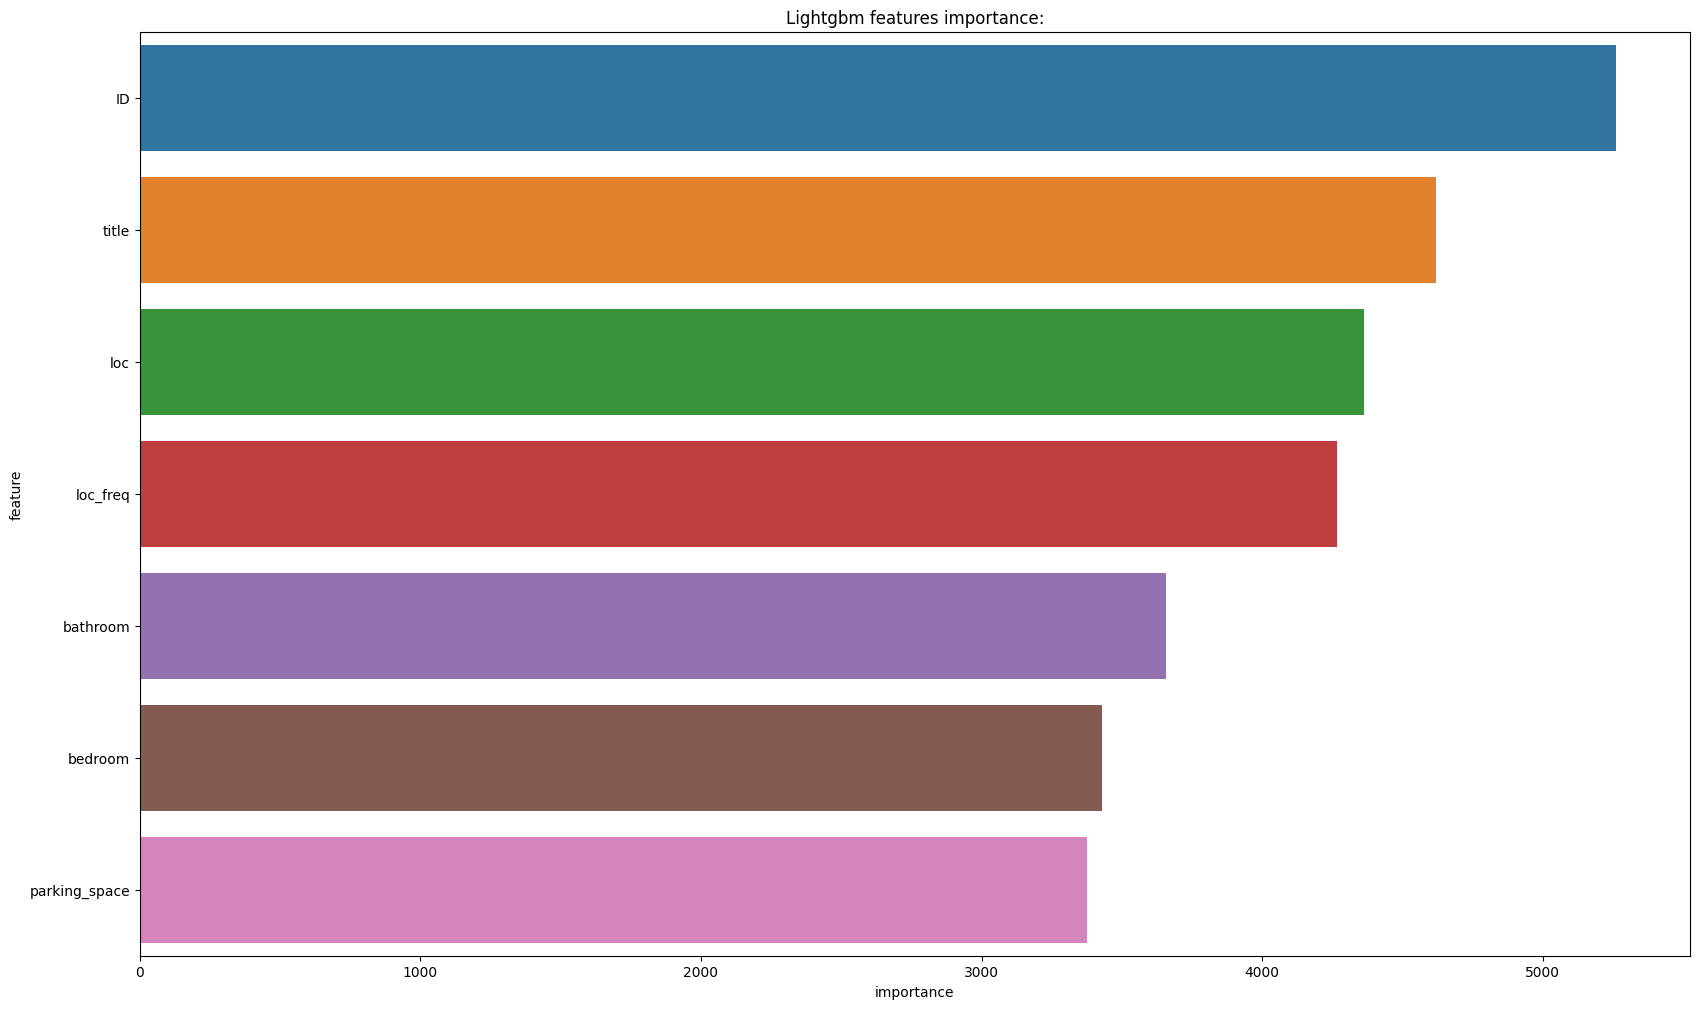

In [32]:
# # 0.7831404345536787
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('Lightgbm features importance:')

# Generating Submission

In [29]:
df_test["price"] = np.mean(fold_pred, axis = 0)

In [30]:
sub = df_test[["ID", "price"]].reset_index(drop = True)

In [32]:
sub.head()

,ID,price
0,845,2.307562e+06
1,1924,9.115610e+05
2,10718,1.135308e+06
3,12076,7.882259e+06
4,12254,1.934149e+06


In [33]:
sub.to_csv('LGB kfold_7_norm.csv', index=False)